# Financial Articles Vector Database Walkthrough

This notebook demonstrates how to use the vector database functionality to process financial articles about AAPL stock and create a searchable vector database using ChromaDB and sentence-transformers.

## Prerequisites

Before starting, make sure you have installed all necessary packages:

In [1]:
# Install required packages
# !pip install chromadb sentence-transformers langchain pandas

## 1. Import Libraries and Setup

First, let's import our custom vector_db module and other necessary libraries:

In [4]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add the scripts directory to the Python path
scripts_dir = os.path.abspath('../scripts')
if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)

# Import our vector database utilities
import vector_db as vdb

# Set up visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Explore the Articles Dataset

Let's first examine the financial articles CSV file to understand its structure:

In [5]:
# Load the articles CSV
articles_path = '../data/articles.csv'
articles_df = pd.read_csv(articles_path)

# Display the first few rows
articles_df.head(2)

,article_id,pubDate,pubDateTZ,title,link,creator,description,source_id,source_name,source_url,source_icon,summary,text
0,d7aa02673ca360f7a97d471201530e30,2025-05-13 18:00:31,UTC,What Does the Market Think About Apple?,https://www.benzinga.com/insights/short-seller...,Benzinga Insights,Apple's (NYSE:AAPL) short percent of float has...,benzinga,Benzinga,https://www.benzinga.com,https://i.bytvi.com/domain_icons/benzinga.png,The company recently reported that it has 108....,Apple's AAPL short percent of float has fallen...
1,339e1027f456beffa954cc954229a0d0,2025-05-13 17:28:31,UTC,"Gordon Reid’s Top Picks for May 13, 2025",https://www.bnnbloomberg.ca/markets/2025/05/13...,BNNBloomberg,NaN,bnnbloomberg_ca,Bnn Bloomberg,https://www.bnnbloomberg.ca,https://i.bytvi.com/domain_icons/bnnbloomberg_...,"Gordon Reid, president and CEO at Goodreid Inv...","Gordon Reid, president and CEO at Goodreid Inv..."


In [6]:
# Basic information about the dataset
print(f"Number of articles: {len(articles_df)}")
print(f"\nColumns in the dataset:\n{articles_df.columns.tolist()}")

# Check for missing values
missing_values = articles_df.isnull().sum()
print(f"\nMissing values per column:\n{missing_values[missing_values > 0]}")

Number of articles: 117

Columns in the dataset:
['article_id', 'pubDate', 'pubDateTZ', 'title', 'link', 'creator', 'description', 'source_id', 'source_name', 'source_url', 'source_icon', 'summary', 'text']

Missing values per column:
creator        12
description    20
summary         6
text            6
dtype: int64


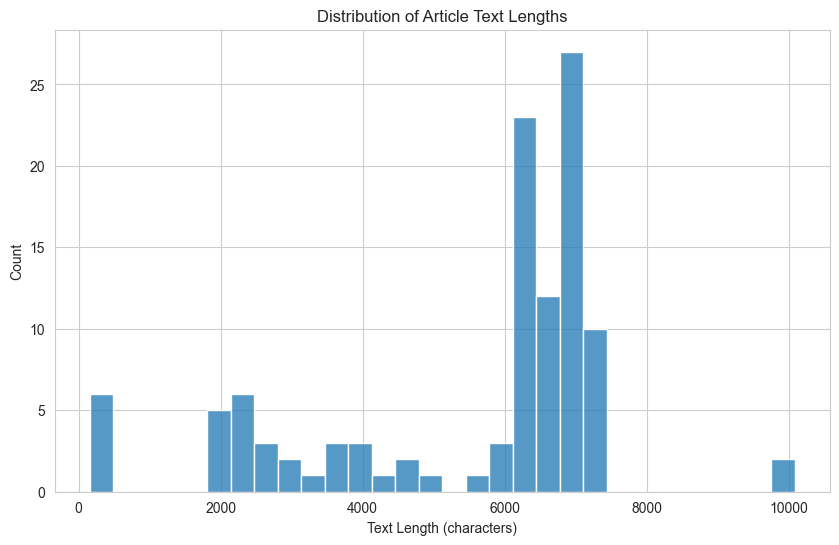

Average article length: 5501.67 characters
Median article length: 6401.00 characters
Min article length: 160.00 characters
Max article length: 10079.00 characters


In [7]:
# Analyze text length distribution
articles_df['text_length'] = articles_df['text'].str.len()

plt.figure(figsize=(10, 6))
sns.histplot(articles_df['text_length'], bins=30)
plt.title('Distribution of Article Text Lengths')
plt.xlabel('Text Length (characters)')
plt.ylabel('Count')
plt.show()

print(f"Average article length: {articles_df['text_length'].mean():.2f} characters")
print(f"Median article length: {articles_df['text_length'].median():.2f} characters")
print(f"Min article length: {articles_df['text_length'].min():.2f} characters")
print(f"Max article length: {articles_df['text_length'].max():.2f} characters")

## 3. Initialize the Embedding Model

Now, let's initialize the embedding model. We'll use the all-MiniLM-L6-v2 model from sentence-transformers, which provides a good balance between quality and efficiency for text embeddings.

In [8]:
# Initialize the embedding model
embedding_function = vdb.init_embedding_model()
print(f"Initialized embedding model: {vdb.DEFAULT_MODEL}")

/Users/giannisalexandrou/.local/share/virtualenvs/trading-agent-Iwjhydeb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initialized embedding model: all-MiniLM-L6-v2


Let's test the embedding model on a sample text to see what the embeddings look like:

In [ ]:
# Get a sample text from our dataset
sample_text = articles_df['text'].iloc[0][:500]  # Taking first 500 chars of first article
print(f"Sample text:\n{sample_text}\n")

# Generate embedding
sample_embedding = embedding_function([sample_text])[0]

# Display embedding information
print(f"Embedding shape: {len(sample_embedding)}")
print(f"Embedding type: {type(sample_embedding)}")
print(f"First 10 values of the embedding:\n{sample_embedding[:10]}")

## 4. Initialize the Vector Database

Next, we'll initialize ChromaDB to store our vector embeddings:

In [ ]:
# Initialize a new database with a specific collection name
collection_name = "apple_financial_articles"
db_path = "../data/chroma_db"

# Clean up any existing collection if needed
# Uncomment the following line to delete an existing collection
# vdb.delete_collection(collection_name=collection_name, persist_directory=db_path)

# Initialize the database and collection
chroma_client, collection = vdb.init_vector_db(
    persist_directory=db_path,
    embedding_function=embedding_function,
    collection_name=collection_name
)

## 5. Process Articles and Load into the Vector Database

Now, we'll split the articles into chunks and load them into the vector database:

In [ ]:
# Create a text splitter with custom chunk size and overlap
text_splitter = vdb.create_text_splitter(chunk_size=800, chunk_overlap=100)
print(f"Created text splitter with chunk size {800} and overlap {100}")

In [ ]:
# Load the articles into the vector database
# Let's load just a few articles for demonstration
num_articles_processed = vdb.load_articles_to_vectordb(
    csv_path=articles_path,
    collection=collection,
    text_splitter=text_splitter,
    batch_size=10,  # Process 10 articles at a time
    max_articles=None  # Set to a number to limit processing, None for all articles
)

print(f"\nTotal articles processed: {num_articles_processed}")

## 6. Query the Vector Database

Now that we have loaded our articles into the vector database, let's perform some semantic searches:

In [ ]:
# Define a function to display search results nicely
def display_search_results(results, limit=3):
    if not results or 'documents' not in results or not results['documents']:
        print("No results found.")
        return
    
    documents = results['documents'][0]
    metadatas = results['metadatas'][0]
    distances = results['distances'][0]
    
    print(f"Found {len(documents)} results. Showing top {min(limit, len(documents))}:\n")
    
    for i in range(min(limit, len(documents))):
        print(f"Result #{i+1} (Similarity: {1-distances[i]:.4f})")
        print(f"Title: {metadatas[i]['title']}")
        print(f"Source: {metadatas[i]['source']}")
        print(f"Date: {metadatas[i]['pubDate']}")
        print(f"Chunk: {metadatas[i]['chunk_index']+1} of {metadatas[i]['total_chunks']}")
        print(f"\nEXCERPT:\n{documents[i][:300]}...\n")
        print("-" * 80)

In [ ]:
# Simple search for Apple's financial performance
query1 = "Apple's financial performance and quarterly earnings"
results1 = vdb.query_vector_db(query1, collection=collection, n_results=5)
display_search_results(results1)

In [ ]:
# Search with metadata filtering (articles from a specific source)
query2 = "Apple stock market sentiment"
results2 = vdb.query_vector_db(
    query2, 
    collection=collection, 
    n_results=5,
    where={"source": "Benzinga"}
)
display_search_results(results2)

In [ ]:
# Search for market trends related to Apple
query3 = "Apple's position relative to competitors in the tech market"
results3 = vdb.query_vector_db(query3, collection=collection, n_results=5)
display_search_results(results3)

## 7. Retrieve Complete Articles

Now, let's demonstrate how to retrieve a complete article by its ID:

In [ ]:
# Get a sample article ID from our results
sample_article_id = results1['metadatas'][0][0]['article_id']
print(f"Retrieving article with ID: {sample_article_id}\n")

# Retrieve the full article
article_data = vdb.get_article_by_id(sample_article_id, collection=collection)

# Display article information
print(f"Article Title: {article_data.get('title', 'N/A')}")
print(f"Publication Date: {article_data.get('pubDate', 'N/A')}")
print(f"Source: {article_data.get('source', 'N/A')}")
print(f"\nARTICLE TEXT (first 500 characters):\n{article_data.get('text', '')[:500]}...")

## 8. Advanced Query Techniques

Let's explore some more advanced query techniques with our vector database:

In [ ]:
# Create a composite query by combining multiple concepts
composite_query = "Apple's earnings impact on stock price and market response"
composite_results = vdb.query_vector_db(composite_query, collection=collection, n_results=3)
display_search_results(composite_results)

In [ ]:
# Compare different queries and their results
queries = [
    "Apple's financial outlook",
    "Apple's product strategy",
    "Apple's stock performance",
    "Market sentiment about Apple"
]

for query in queries:
    print(f"\nQUERY: {query}")
    print("-" * 50)
    results = vdb.query_vector_db(query, collection=collection, n_results=1)
    display_search_results(results, limit=1)

## 9. Vector Database Statistics and Insights

Let's get some information about our vector database:

In [ ]:
# Get collection info
collection_info = collection.count()
print(f"Total documents in collection: {collection_info}")

# Get unique article IDs
all_metadata = collection.get(include=["metadatas"])["metadatas"]
unique_articles = set(meta["article_id"] for meta in all_metadata)
print(f"Number of unique articles: {len(unique_articles)}")

# Average chunks per article
avg_chunks = collection_info / len(unique_articles) if unique_articles else 0
print(f"Average chunks per article: {avg_chunks:.2f}")

## 10. Conclusion

In this notebook, we have demonstrated how to:

1. Initialize a sentence-transformer embedding model
2. Set up a ChromaDB vector database
3. Process financial articles by splitting them into chunks
4. Store these chunks with metadata in the vector database
5. Perform semantic searches on the articles
6. Retrieve and reconstruct full articles

This approach allows for efficient retrieval of relevant financial information from a large collection of articles about Apple stock. The vector database can be extended with more articles and integrated into applications for financial analysis, market sentiment tracking, or automated reporting.